In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [34]:
epsilon = 1e-5

def close_enough(A, B, epsilon=epsilon):
    if A == B:
        return True
    
    exponent = np.floor(np.log10(A))
    
    return np.abs(A - B) < 10 ** exponent * epsilon
    
def solve_linear_system(A, f, epsilon=epsilon): # Методом Зейделя
    N = len(f)
    
    A = np.copy(A)
    f = np.copy(f)
    x_old = np.zeros(N)
    x_new = np.zeros(N)
    
    def norm(vec):
        return np.max(np.abs(vec))
    
    while not close_enough(norm(A @ x_old - f), 0, epsilon=epsilon):
        for i in range(N):
            x_new[i] = 0
            for j in range(i):
                x_new[i] += + A[i][j] * x_new[j]
            for j in range(i + 1, N):
                x_new[i] += A[i][j] * x_old[j]
            x_new[i] = (f[i] - x_new[i]) / A[i][i]
        x_old = x_new

    return x_new

def derivative(f, x, i, j, h=5e-5):
    x_1 = np.copy(x)
    x_1[j] += h
    x_2 = np.copy(x) 
    x_2[j] -= h
    return (f(x_1).ravel()[i] - f(x_2).ravel()[i]) / (2 * h)

def solve_newton(f, x, epsilon=epsilon):
    x = np.copy(x)
    original_shape = x.shape
    x = x.ravel()
    
    def f_flat(x):
        return f(x.ravel().reshape(original_shape)).ravel()
    
    N = len(f_flat(x))
    
    while not close_enough(np.sum(np.abs(f_flat(x.reshape(original_shape)))), 0):
        J = np.array([[0.0] * N] * N)

        for i in range(N):
            for j in range(N):
                J[i][j] = derivative(f_flat, x, i, j)

        x = x + solve_linear_system(J, -f_flat(x), epsilon=epsilon)
    
    return x.reshape(original_shape)

################################################

class ButcherTable:
    def __init__(self, A):
        self.a = []
        self.c = []
        self.b = []
        
        self.s = len(A) - 1
        
        for i in range(self.s):
            self.a.append([])
            for j in range(self.s):
                self.a[i].append(A[i][j + 1])

            self.b.append(A[self.s][i + 1])
            
            self.c.append(A[i][0])

def solve_runge_kutta_explicit(tau, t, x, f, method, epsilon=epsilon):
    k = []
    for i in range(method.s):
        arg_1 = t + method.s * tau
        arg_2 = 0
        for j in range(i):
            arg_2 += method.a[i][j] * k[j]
        arg_2 *= tau
        arg_2 += x
        k.append(f(arg_1, arg_2))
    
    k = np.array(k)
    
    # print(f"explicit: {k}")
    
    ret_val = x - x
    for i in range(method.s):
        ret_val += method.b[i] * k[i]
    ret_val *= tau
    ret_val += x
        
    return ret_val

def solve_runge_kutta_implicit(tau, t, x, f, method, epsilon=epsilon):
    def equation(k_0):
        k = []
        for i in range(method.s):
            arg_1 = t + method.s * tau
            arg_2 = 0
            for j in range(i):
                arg_2 += method.a[i][j] * k_0[j]
            arg_2 *= tau
            arg_2 += x
            k.append(f(arg_1, arg_2))
        
        k = np.array(k)
        return k - k_0
        
    k = solve_newton(equation, np.array([f(t, x) for _ in range(method.s)]), epsilon=epsilon)
    
    # print(f"implicit: {k}")
    
    ret_val = x - x
    for i in range(method.s):
        ret_val += method.b[i] * k[i]
    ret_val *= tau
    ret_val += x
    
    return ret_val

################################################

def solve_adams(tau, t, x, f, N):
    if N > len(x):
        return solve_adams(tau, t, x, f, len(x))
    else:
        n = len(x) - 1
        match N:
            case 1:
                return x[n] + tau * f(t, x[n])
            case 2:
                return x[n] + tau * (3 * f(t, x[n]) - 1 * f(t, x[n - 1])) / 2
            case 3:
                return x[n] + tau * (23 * f(t, x[n]) - 16 * f(t, x[n - 1]) + 5 * f(t, x[n - 2])) / 12
            case 4:
                return x[n] + tau * (55 * f(t, x[n]) - 59 * f(t, x[n - 1]) + 37 * f(t, x[n - 2]) - 9 * f(t, x[n - 3])) / 24

################################################

def solve_backward_differentiation_explicit(tau, t, x, f, N):
    if N > len(x):
        return solve_backward_differentiation_explicit(tau, t, x, f, len(x))
    else:
        n = len(x) - 1
        match N:
            case 1:
                return x[n] + tau * f(t, x[n])
            case 2:
                return 2 / 3 * (tau * f(t, x[n]) - 1 / 2 * x[n - 1] + 2 * x[n])
            case 3:
                return 6 / 11 * (tau * f(t, x[n]) + 1 / 3 * x[n - 2] - 3 / 2 * x[n - 1] + 3 * x[n])
            case 4:
                return 12 / 25 * (tau * f(t, x[n]) - 1 / 4 * x[n - 3] + 4 / 3 * x[n - 2] - 3 * x[n - 1] + 4 * x[n])

def solve_backward_differentiation_implicit(tau, t, x, f, N, epsilon=epsilon):
    if N > len(x):
        return solve_backward_differentiation_implicit(tau, t, x, f, len(x), epsilon=epsilon)
    else:
        n = len(x) - 1
        match N:
            case 1:
                return solve_newton(lambda a: x[n] + tau * f(t, a) - a, x[n], epsilon=epsilon)
            case 2:
                return solve_newton(lambda a: 2 / 3 * (tau * f(t, a) - 1 / 2 * x[n - 1] + 2 * x[n]) - a, x[n], epsilon=epsilon)
            case 3:
                return solve_newton(lambda a: 6 / 11 * (tau * f(t, a) + 1 / 3 * x[n - 2] - 3 / 2 * x[n - 1] + 3 * x[n]) - a, x[n], epsilon=epsilon)
            case 4:
                return solve_newton(lambda a: 12 / 25 * (tau * f(t, a) - 1 / 4 * x[n - 3] + 4 / 3 * x[n - 2] - 3 * x[n - 1] + 4 * x[n]) - a, x[n], epsilon=epsilon)


In [35]:
class Solution:
    def __init__(self, t, x, x_dot):
        self.t = t
        self.x = x
        self.x_dot = x_dot


def plot_solutions(solution_containers, multidimensionals_solution=False):
    plt.figure(figsize=(12, 5))
    for solution_container in solution_containers:
        if multidimensionals_solution:
            for i in range(len(solution_container.solution.x[0])):
                plt.plot(solution_container.solution.t, [a[i] for a in solution_container.solution.x], label=f"{solution_container.name} (order: {solution_container.order}) ({i})") 
        else:
            plt.plot(solution_container.solution.t, solution_container.solution.x, label=f"{solution_container.name} (order: {solution_container.order})") 
    plt.xlabel("$t$")
    plt.ylabel("$x$")
    plt.title("Интегральные кривые")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
    plt.show()
    
    if not multidimensionals_solution:
        plt.figure(figsize=(12, 5))
        for solution_container in solution_containers:
            plt.plot(solution_container.solution.x, solution_container.solution.x_dot, label=f"{solution_container.name} (order: {solution_container.order})")    
        plt.xlabel("$x$")
        plt.ylabel("$\\dot(x)$")
        plt.title("Фазовые траектории")
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
        plt.show()


# Лабораторная работа 1 Системы ОДУ

$$ y'' + e (y^2 - 1)y'+ y = 0, e > 0, y(0) = 2, y'(0) = 0 $$
$$
    \begin{cases}
        x'= z \\
        z' = e(1-x^2) z - x \\
        x(0) = 2 \\
        z(0) = 0
    \end{cases}
$$

In [36]:
def f(t, x):
    return np.array([
        x[1],
        np.exp(1) * (1 - x[0] ** 2) * x[1] - x[0],
    ])

## Методы Рунге-Кутта
[Источник](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods)

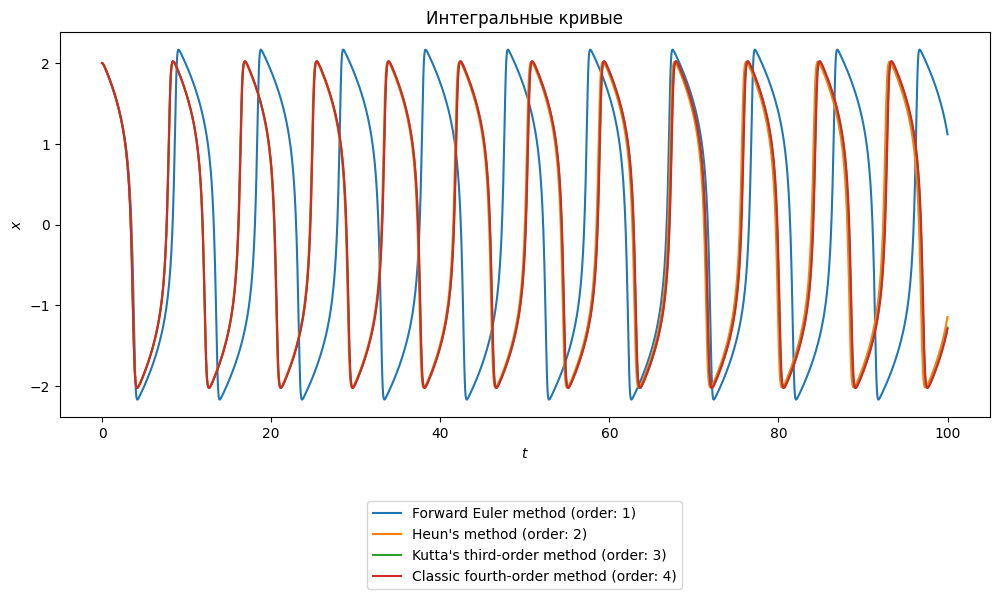

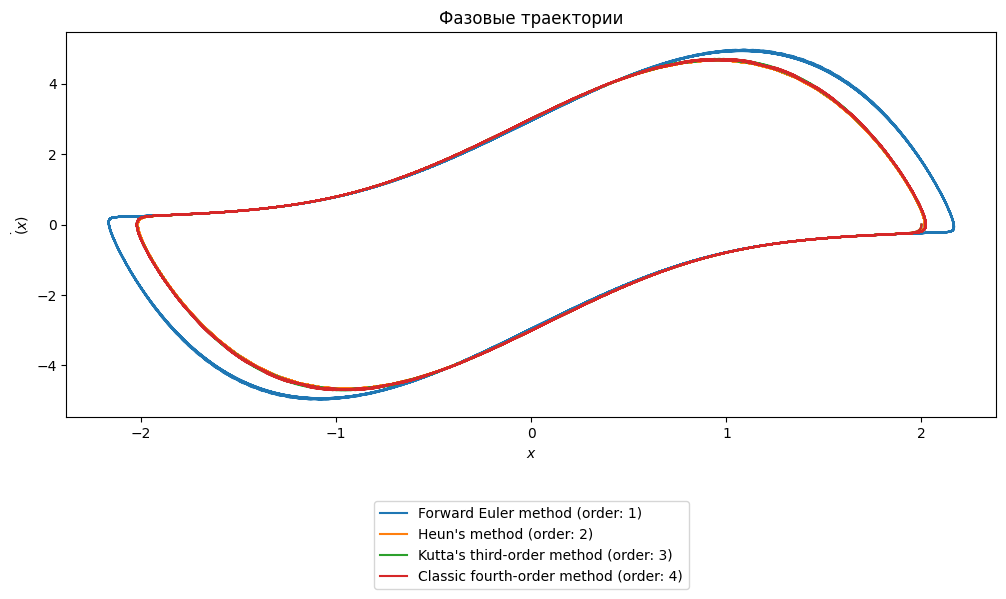

In [37]:
tau = 0.05
t_stop = 100

class RungeKuttaMethod:
    def __init__(self, name: str, order: int, table: ButcherTable):
        self.name = name
        self.order = order
        self.table = table
        self.solution = None
    
    def set_solution(self, t, x, x_dot):
        self.solution = Solution(t, x, x_dot)

methods: list[RungeKuttaMethod] = []

methods.append(
    RungeKuttaMethod(
        "Forward Euler method",
        1,
        ButcherTable(
            [
                [0.0, 0.0],
                [0.0, 1.0],
            ]
        )
    )
)

methods.append(
    RungeKuttaMethod(
        "Heun's method",
        2,
        ButcherTable(
            [
                [0.0, 0.0, 0.0],
                [1.0, 1.0, 0.0],
                [0.0, 1/2, 1/2],
            ]
        )
    )
)

methods.append(
    RungeKuttaMethod(
        "Kutta's third-order method",
        3,
        ButcherTable(
            [
                [0.0,  0.0, 0.0, 0.0],
                [1/2,  1/2, 0.0, 0.0],
                [1.0, -1.0, 2.0, 0.0],
                [0.0,  1/6, 2/3, 1/6],
            ]
        )
    )
)

methods.append(
    RungeKuttaMethod(
        "Classic fourth-order method",
        4,
        ButcherTable(
            [
                [0.0, 0.0, 0.0, 0.0, 0.0],
                [1/2, 1/2, 0.0, 0.0, 0.0],
                [1/2, 0.0, 1/2, 0.0, 0.0],
                [1.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 1/6, 1/3, 1/3, 1/6],
            ]
        )
    )
)

for method in methods:
    t = [0]
    i = 1
        
    x = [
        np.array([2.0, 0.0])
    ]

    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_runge_kutta_explicit(tau, t[i - 1], x[i - 1], f, method.table))
        i += 1
    
    method.set_solution(
        t, 
        np.array([a[0] for a in x]),
        np.array([a[1] for a in x]),
    )
    
plot_solutions(methods)


## Методы Адамса

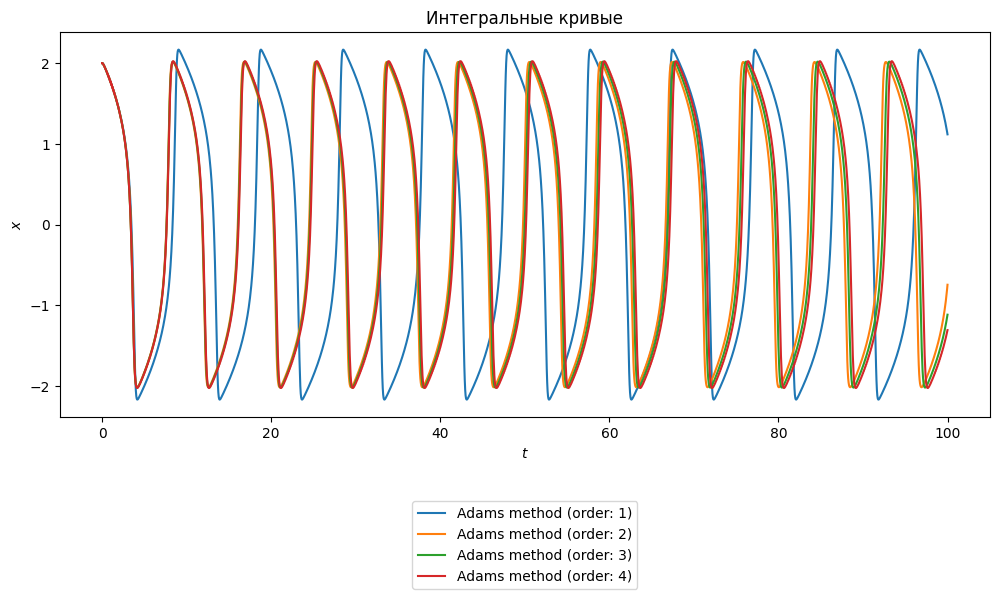

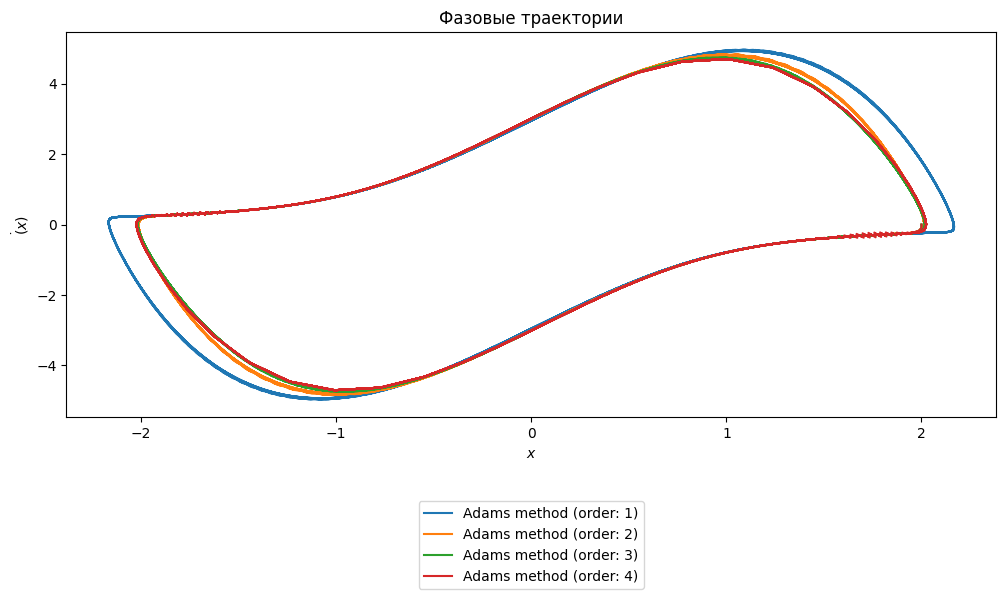

In [38]:
tau = 0.05
t_stop = 100

class AdamsMethod:
    def __init__(self, order: int):
        self.name = "Adams method"
        self.order = order
        self.solution = None
    
    def set_solution(self, t, x, x_dot):
        self.solution = Solution(t, x, x_dot)

methods: list[AdamsMethod] = []

methods.append(
    AdamsMethod(
        1,
    )
)

methods.append(
    AdamsMethod(
        2,
    )
)

methods.append(
    AdamsMethod(
        3,
    )
)

methods.append(
    AdamsMethod(
        4,
    )
)

for method in methods:
    t = [0]
    i = 1
        
    x = [
        np.array([2.0, 0.0])
    ]

    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_adams(tau, t[i - 1], x, f, method.order))
        i += 1
    
    method.set_solution(
        t, 
        np.array([a[0] for a in x]),
        np.array([a[1] for a in x]),
    )
    
plot_solutions(methods)


## Явные методы дифференцирования назад

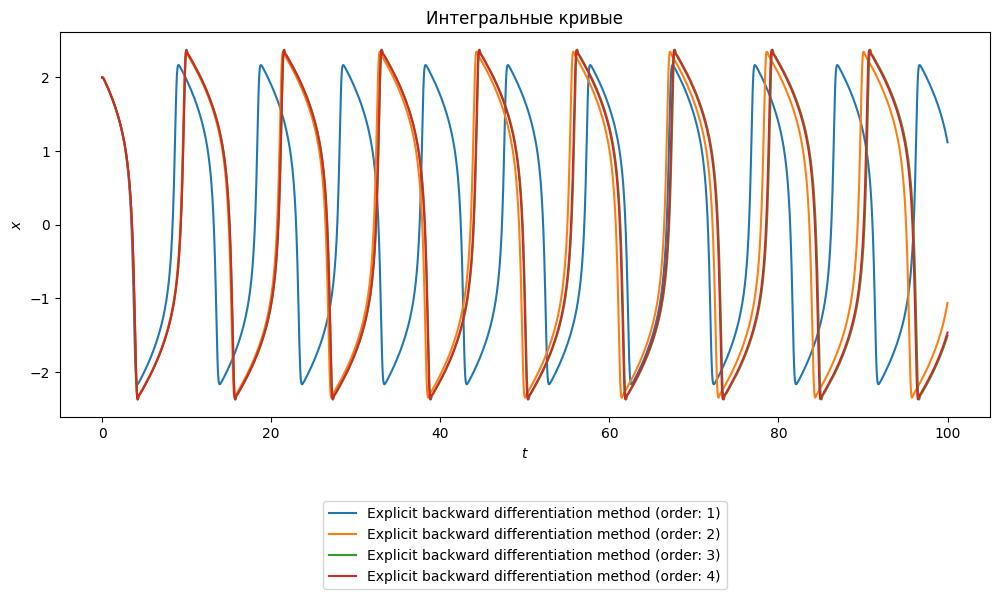

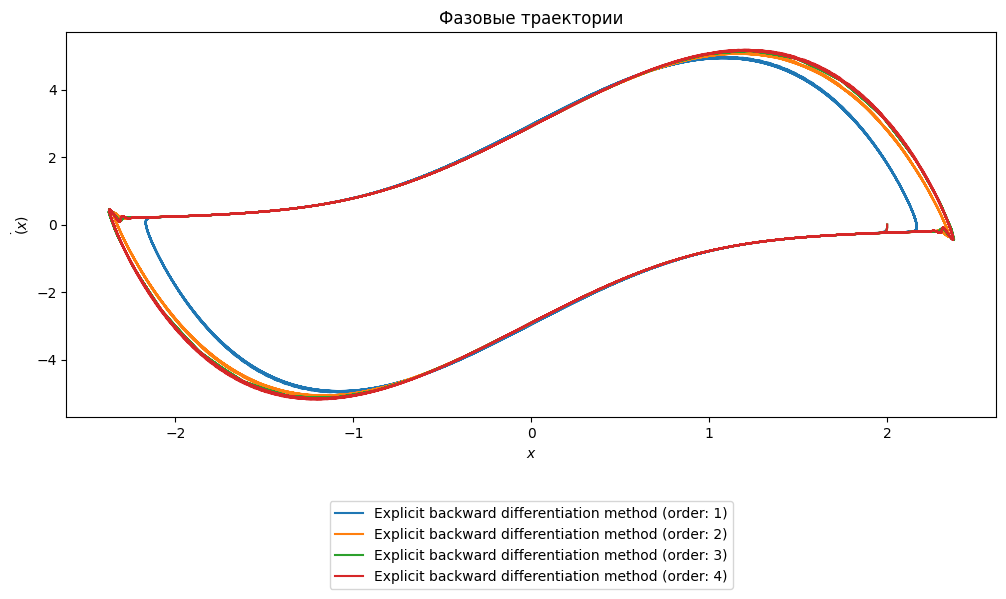

In [39]:
tau = 0.05
t_stop = 100
class ExplicitBackwardDiffenetiationMethod:
    def __init__(self, order: int):
        self.name = "Explicit backward differentiation method"
        self.order = order
        self.solution = None
    
    def set_solution(self, t, x, x_dot):
        self.solution = Solution(t, x, x_dot)

methods: list[ExplicitBackwardDiffenetiationMethod] = []

methods.append(
    ExplicitBackwardDiffenetiationMethod(
        1,
    )
)

methods.append(
    ExplicitBackwardDiffenetiationMethod(
        2,
    )
)

methods.append(
    ExplicitBackwardDiffenetiationMethod(
        3,
    )
)

methods.append(
    ExplicitBackwardDiffenetiationMethod(
        4,
    )
)

for method in methods:
    t = [0]
    i = 1
        
    x = [
        np.array([2.0, 0.0])
    ]

    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_backward_differentiation_explicit(tau, t[i - 1], x, f, method.order))
        i += 1
    
    method.set_solution(
        t, 
        np.array([a[0] for a in x]),
        np.array([a[1] for a in x]),
    )
    
plot_solutions(methods)


# Лабораторная работа 2 Системы ОДУ (жёсткий вариант)

$$
\begin{cases}
    \dot{y}_1 = 77.27 (y_2 + y_1 (1 - 8.375 \cdot 10^{-6} y_1 - y_2)) \\
    \dot{y}_2 = \frac{1}{77.27} (y_3 - (1 + y_1) y_2) \\
    \dot{y}_3 = 0.161 (y_1 - y_2)
\end{cases}
$$

In [40]:
def f(_, x):
    return np.array([
        77.27 * (x[1] + x[0] * (1 - 8.375e-6 * x[0] - x[1])),
        1 / 77.27 * (x[2] - (1 + x[0]) * x[1]),
        0.161 * (x[0] - x[1])
    ])

Gauss-Legendre method (non-adaptive)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
2

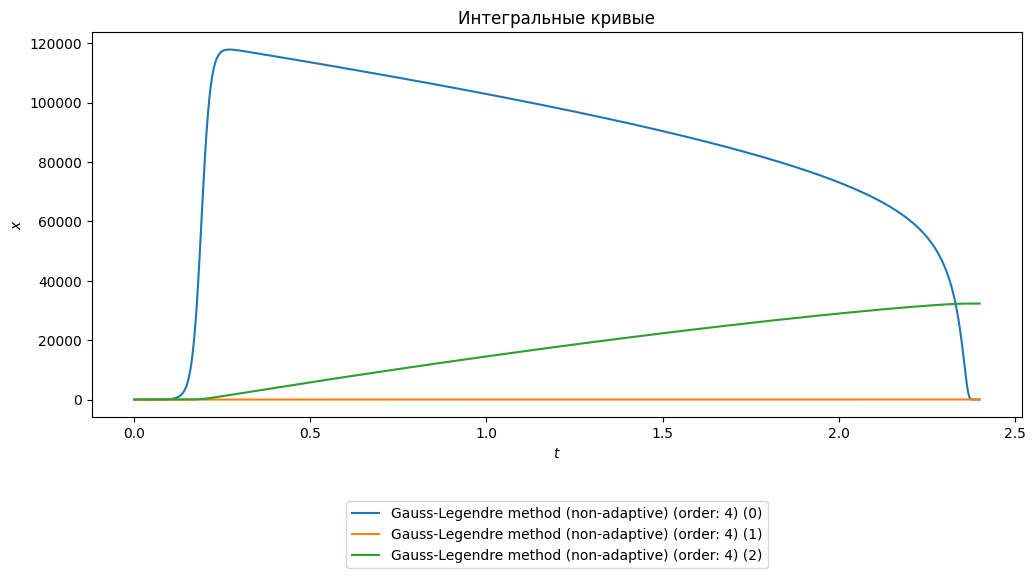

Classic fourth-order method


KeyboardInterrupt: 

In [44]:
tau = 0.001
# t_stop = 10
t_stop = 2.4

methods: list[RungeKuttaMethod] = []

methods.append(
    RungeKuttaMethod(
        "Gauss-Legendre method (non-adaptive)",
        4,
        ButcherTable(
            [
                [1 / 2 - np.sqrt(3) / 6, 1 / 4                 , 1 / 4 - np.sqrt(3) / 6],
                [1 / 2 + np.sqrt(3) / 6, 1 / 4 + np.sqrt(3) / 6, 1 / 4                 ],
                [0                     , 1 / 2                 , 1 / 2                 ],
            ]
        )
    )
)

# methods.append(
#     RungeKuttaMethod(
#         "Classic fourth-order method",
#         4,
#         ButcherTable(
#             [
#                 [0.0, 0.0, 0.0, 0.0, 0.0],
#                 [1/2, 1/2, 0.0, 0.0, 0.0],
#                 [1/2, 0.0, 1/2, 0.0, 0.0],
#                 [1.0, 0.0, 0.0, 1.0, 0.0],
#                 [0.0, 1/6, 1/3, 1/3, 1/6],
#             ]
#         )
#     )
# )

for method in methods:
    t = [0]
    i = 1
        
    x = [
        np.array([0.05, 0.05, 0.05])
    ]

    print(method.name)
    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_runge_kutta_implicit(tau, t[i - 1], x[i - 1], f, method.table, epsilon=1e-3))
        i += 1
        
        print(i)
    
    method.set_solution(
        t, 
        np.array(x),
        np.array(x),
    )
    
    plot_solutions([method], multidimensionals_solution=True)

plot_solutions(methods, multidimensionals_solution=True)


In [47]:
# tau = 0.01
tau = 0.01
t_stop = 10

class ImplicitBackwardDiffenetiationMethod:
    def __init__(self, order: int):
        self.name = "Implicit backward differentiation method"
        self.order = order
        self.solution = None
    
    def set_solution(self, t, x, x_dot):
        self.solution = Solution(t, x, x_dot)

methods: list[ImplicitBackwardDiffenetiationMethod] = []

methods.append(
    ImplicitBackwardDiffenetiationMethod(
        1,
    )
)

methods.append(
    ImplicitBackwardDiffenetiationMethod(
        2,
    )
)

methods.append(
    ImplicitBackwardDiffenetiationMethod(
        3,
    )
)

methods.append(
    ImplicitBackwardDiffenetiationMethod(
        4,
    )
)

for method in methods:
    t = [0]
    i = 1

    x = [
        np.array([0.05, 0.05, 0.05])
    ]

    print(method.name)
    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_backward_differentiation_implicit(tau, t[i - 1], x, f, method.order, epsilon=1e-1))
        i += 1
        
        print(i)
    
    method.set_solution(
        t, 
        np.array(x),
        np.array(x),
    )
    
plot_solutions(methods, multidimensionals_solution=True)

Implicit backward differentiation method


KeyboardInterrupt: 

# Лабораторная работа 3 Линейная КУ

$$y''-P^2(x)y=f(x)$$
$$P^2(x) = 10 + sin(2 \pi x)$$
$$f(x) = cos(2 \pi x)$$

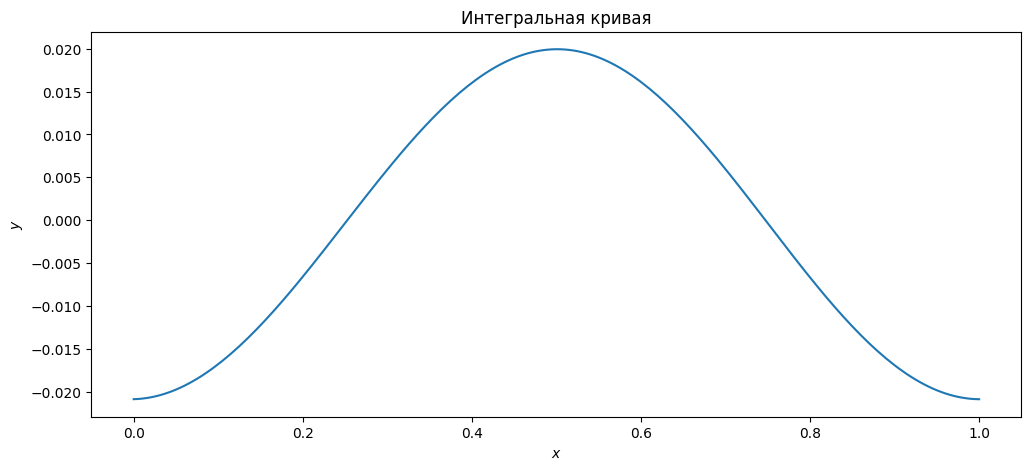

In [33]:
def f(x):
    return np.cos(2 * np.pi * x)

def P2(x):
    return 10 + np.sin(2 * np.pi * x)

h = 0.005

x_0 = 0
x_N = 1

N = int(np.round((x_N - x_0) / h)) + 1

A = np.zeros((N, N))
b = np.zeros(N)

for i in range(N):
    A[i][(i + 1) % N] = 1 / h**2
    A[i][(i + 0) % N] = -2 / h**2 - P2(i * h)
    A[i][(i - 1) % N] = 1 / h**2
    
    b[i] = f(i * h)

for i in range(1, N):
    b[i] -= b[i - 1] * A[i][i - 1] / A[i - 1][i - 1]
    A[i] -= A[i - 1] * A[i][i - 1] / A[i - 1][i - 1]

for i in range(0, N - 1):
    b[N - 1] -= b[i] * A[N - 1][i] / A[i][i]
    A[N - 1] -= A[i] * A[N - 1][i] / A[i][i]

for i in range(0, N - 1):
    b[i] -= b[N - 1] * A[i][N - 1] / A[N - 1][N - 1]
    A[i] -= A[N - 1] * A[i][N - 1] / A[N - 1][N - 1]

for i in range(N - 2, -1, -1):
    b[i] -= b[i + 1] * A[i][i + 1] / A[i + 1][i + 1]
    A[i] -= A[i + 1] * A[i][i + 1] / A[i + 1][i + 1]

for i in range(N):
    b[i] /= A[i][i]

plt.figure(figsize=(12, 5))
plt.plot(np.linspace(x_0, x_N, N), b) 
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Интегральная кривая")
plt.show()
